In [1]:
# STEP 1 — Write kaggle.json from creds + download Kaggle Insurance dataset (regression)

import os, sys, shutil, zipfile, subprocess, textwrap, pathlib, json

# ==== FILL THESE FROM YOUR kaggle.json (Kaggle > Account > Create New API Token) ====
KAGGLE_USERNAME = "iamvijayshankar"   # e.g., "anjalijha1507"
KAGGLE_KEY      = "5432ac578dbd76cbbfa10a1935b6e4aa"        # long secret string from kaggle.json
# ================================================================================

KAGGLE_DATASET = "mirichoi0218/insurance"          # Regression: predict 'charges'
DATA_ROOT      = os.path.abspath("./data")
DATASET_DIR    = os.path.join(DATA_ROOT, "insurance_regression")

print("KAGGLE_DATASET:", KAGGLE_DATASET)
print("DATA_ROOT:", DATA_ROOT)
print("DATASET_DIR:", DATASET_DIR)

# 1) Ensure kaggle CLI is installed for this Python
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

# 2) Create ~/.kaggle/kaggle.json from creds above
home = str(pathlib.Path.home())
kaggle_dir = os.path.join(home, ".kaggle")
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
os.makedirs(kaggle_dir, exist_ok=True)

if not KAGGLE_USERNAME or not KAGGLE_KEY:
    raise ValueError("Please fill KAGGLE_USERNAME and KAGGLE_KEY above (from your kaggle.json).")

with open(kaggle_json_path, "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
try:
    os.chmod(kaggle_json_path, 0o600)  # fine if it doesn't apply on Windows
except Exception:
    pass

# Also set env vars (Kaggle CLI supports these too)
os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

# 3) Make local folders
os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

# 4) Download dataset zip to DATA_ROOT
print("\nDownloading from Kaggle…")
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", KAGGLE_DATASET,
    "-p", DATA_ROOT,
    "--force"
], check=True)

# 5) Unzip all zips into DATASET_DIR
for fname in os.listdir(DATA_ROOT):
    if fname.lower().endswith(".zip"):
        zpath = os.path.join(DATA_ROOT, fname)
        print("Unzipping:", zpath)
        with zipfile.ZipFile(zpath, "r") as zf:
            zf.extractall(DATASET_DIR)
        os.remove(zpath)

print("\nContents of dataset directory:")
for f in os.listdir(DATASET_DIR):
    print(" -", f)

KAGGLE_DATASET: mirichoi0218/insurance
DATA_ROOT: /Users/spartan/Documents/data
DATASET_DIR: /Users/spartan/Documents/data/insurance_regression

Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
License(s): DbCL-1.0

Unzipping: /Users/spartan/Documents/data/insurance.zip

Contents of dataset directory:
 - insurance.csv


100%|██████████| 16.0k/16.0k [00:00<00:00, 31.5MB/s]


In [2]:
# STEP 2 — Load CSV, sanity checks, and train/valid split (regression)

import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Paths (must match Step 1)
DATA_ROOT   = os.path.abspath("./data")
DATASET_DIR = os.path.join(DATA_ROOT, "insurance_regression")
CSV_PATH    = os.path.join(DATASET_DIR, "insurance.csv")

# 2.1 Load
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH)
print("Shape:", df.shape)
display(df.head())

# 2.2 Quick sanity checks
print("\nColumns:", list(df.columns))
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows (before drop):", df.duplicated().sum())

# (Optional) drop perfect duplicates if any
if df.duplicated().any():
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New shape:", df.shape)

# 2.3 Target & features
TARGET = "charges"
assert TARGET in df.columns, f"Expected target '{TARGET}' not found. Found: {list(df.columns)}"

y = df[TARGET]
X = df.drop(columns=[TARGET])

# 2.4 Train/validation split (no stratify for regression)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTrain: {X_train.shape} | Valid: {X_valid.shape}")

# 2.5 Peek at numeric summary (helps spot outliers / ranges)
display(df.describe(include='all').T)

Loaded: /Users/spartan/Documents/data/insurance_regression/insurance.csv
Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Duplicate rows (before drop): 1
Duplicates removed. New shape: (1337, 7)

Train: (1069, 6) | Valid: (268, 6)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1337.0,NaN,NaN,NaN,39.222139,14.044333,18.0,27.0,39.0,51.0,64.0
sex,1337,2,male,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1337.0,NaN,NaN,NaN,30.663452,6.100468,15.96,26.29,30.4,34.7,53.13
children,1337.0,NaN,NaN,NaN,1.095737,1.205571,0.0,0.0,1.0,2.0,5.0
smoker,1337,2,no,1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1337,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1337.0,NaN,NaN,NaN,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


Numeric cols: ['age', 'bmi', 'children']
Categorical cols: ['sex', 'smoker', 'region']
LinearRegression — RMSE: 5,983.61 | MAE: 4,205.56 | R²: 0.805


/opt/homebrew/Caskroom/miniforge/base/envs/nb311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


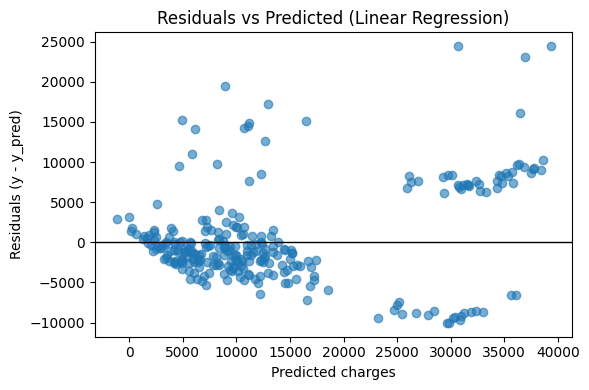

In [3]:
# STEP 3 — Preprocess (numeric+categorical) + Baseline Linear Regression

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 3.1 Identify numeric vs categorical columns
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# 3.2 Build preprocessing: impute + scale (nums), impute + one-hot (cats)
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

# 3.3 Baseline model: Linear Regression
linreg = Pipeline([
    ("prep", preprocess),
    ("lr", LinearRegression())
])

# 3.4 Fit and predict
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_valid)

# 3.5 Evaluate
rmse = mean_squared_error(y_valid, y_pred, squared=False)
mae  = mean_absolute_error(y_valid, y_pred)
r2   = r2_score(y_valid, y_pred)

print(f"LinearRegression — RMSE: {rmse:,.2f} | MAE: {mae:,.2f} | R²: {r2:.3f}")

# 3.6 Quick residuals plot
residuals = y_valid - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Predicted charges")
plt.ylabel("Residuals (y - y_pred)")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.tight_layout()
plt.show()

# Keep for next step
baseline_model = linreg

RandomForestRegressor — RMSE: 4,643.89 | MAE: 2,569.24 | R²: 0.883

=== Validation Metrics (Side-by-Side) ===
LinearRegression      -> RMSE: 5,983.61 | MAE: 4,205.56 | R²: 0.805
RandomForestRegressor -> RMSE: 4,643.89 | MAE: 2,569.24 | R²: 0.883


/opt/homebrew/Caskroom/miniforge/base/envs/nb311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/nb311/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


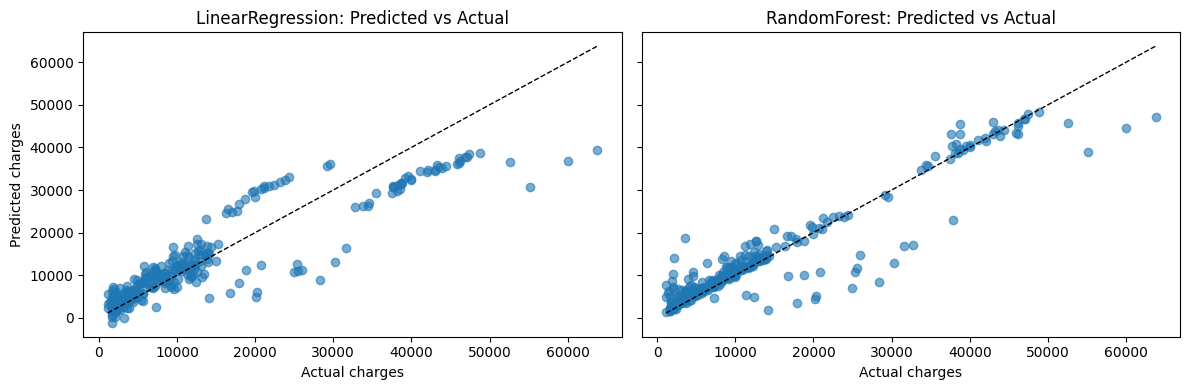

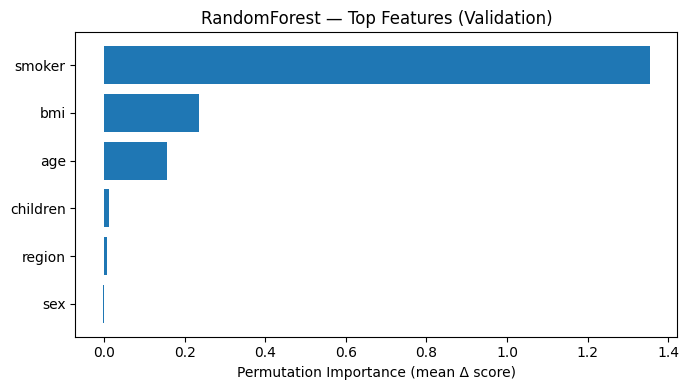


Best model selected for next step: RandomForestRegressor


In [4]:
# STEP 4 — Stronger model (RandomForestRegressor) + comparison + permutation importance

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# 4.1 Build RF pipeline reusing the same preprocess transformer from Step 3
rf_model = Pipeline([
    ("prep", preprocess),  # from Step 3
    ("rf", RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 4.2 Fit & predict
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_valid)

# 4.3 Evaluate RF
rmse_rf = mean_squared_error(y_valid, y_pred_rf, squared=False)
mae_rf  = mean_absolute_error(y_valid, y_pred_rf)
r2_rf   = r2_score(y_valid, y_pred_rf)
print(f"RandomForestRegressor — RMSE: {rmse_rf:,.2f} | MAE: {mae_rf:,.2f} | R²: {r2_rf:.3f}")

# 4.4 Evaluate baseline again for side-by-side numbers
y_pred_bl = baseline_model.predict(X_valid)
rmse_bl = mean_squared_error(y_valid, y_pred_bl, squared=False)
mae_bl  = mean_absolute_error(y_valid, y_pred_bl)
r2_bl   = r2_score(y_valid, y_pred_bl)

print("\n=== Validation Metrics (Side-by-Side) ===")
print(f"LinearRegression      -> RMSE: {rmse_bl:,.2f} | MAE: {mae_bl:,.2f} | R²: {r2_bl:.3f}")
print(f"RandomForestRegressor -> RMSE: {rmse_rf:,.2f} | MAE: {mae_rf:,.2f} | R²: {r2_rf:.3f}")

# 4.5 Plots: Predicted vs Actual for both models
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].scatter(y_valid, y_pred_bl, alpha=0.6)
ax[0].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', linewidth=1)
ax[0].set_title("LinearRegression: Predicted vs Actual")
ax[0].set_xlabel("Actual charges"); ax[0].set_ylabel("Predicted charges")

ax[1].scatter(y_valid, y_pred_rf, alpha=0.6)
ax[1].plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', linewidth=1)
ax[1].set_title("RandomForest: Predicted vs Actual")
ax[1].set_xlabel("Actual charges")
plt.tight_layout()
plt.show()

# 4.6 Permutation importance (original feature names)
# This permutes columns BEFORE preprocessing, so importance is attributed to original features.
perm = permutation_importance(
    rf_model, X_valid, y_valid,
    n_repeats=10, random_state=42, n_jobs=-1
)
importances = perm.importances_mean
feat_names = np.array(X_train.columns)

# Top 10 features
idx = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(7, 4))
plt.barh(range(len(idx)), importances[idx][::-1])
plt.yticks(range(len(idx)), feat_names[idx][::-1])
plt.xlabel("Permutation Importance (mean Δ score)")
plt.title("RandomForest — Top Features (Validation)")
plt.tight_layout()
plt.show()

# Keep reference to best model for the next step
best_model = rf_model if rmse_rf <= rmse_bl else baseline_model
print("\nBest model selected for next step:",
      "RandomForestRegressor" if best_model is rf_model else "LinearRegression")

In [5]:
# STEP 5 — Save artifact (model + metadata) + reload & inference demo (regression)

import os, joblib, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone

# 5.1 Refit a clean production pipeline on ALL data (X, y) using the chosen best model
# If best_model is already a Pipeline (ours are), clone & refit on ALL data.
prod_pipeline = clone(best_model)
prod_pipeline.fit(X, y)

# 5.2 Save artifact with helpful metadata
os.makedirs("./artifacts", exist_ok=True)
artifact = {
    "model": prod_pipeline,
    "model_name": "RandomForestRegressor" if isinstance(prod_pipeline.named_steps.get("rf"), RandomForestRegressor) else "LinearRegression",
    "features": list(X.columns),
    "target": "charges"
}
artifact_path = "./artifacts/insurance_regression_best_model.joblib"
joblib.dump(artifact, artifact_path)
print(f"✅ Saved artifact to: {artifact_path}")
print(f"   Includes: model='{artifact['model_name']}', features={len(artifact['features'])}, target='{artifact['target']}'")

# 5.3 Reload + inference smoke test on real validation rows
loaded = joblib.load(artifact_path)
pipe   = loaded["model"]
feats  = loaded["features"]

# Ensure feature order matches
Xv = X_valid[feats].copy()
pred_v = pipe.predict(Xv[:5])
print("\nValidation sample predictions (first 5):")
for i, p in enumerate(pred_v, 1):
    print(f"Row{i}: predicted charges = {p:,.2f} | actual = {float(y_valid.iloc[i-1]):,.2f}")

# 5.4 One manual row demo (build from training medians/modes)
example = {}
for c in feats:
    if c in X.select_dtypes(include=[np.number]).columns:
        example[c] = float(X[c].median())
    else:
        # pick the most frequent category seen in training
        example[c] = X[c].mode(dropna=True).iloc[0] if not X[c].mode(dropna=True).empty else X[c].iloc[0]

X_one = pd.DataFrame([example], columns=feats)
pred_one = pipe.predict(X_one)[0]
print("\nManual row — predicted charges:", f"{pred_one:,.2f}")

# 5.5 (Optional) Save a tiny helper for later batch inference
def predict_charges(df_new: pd.DataFrame, artifact_file: str = artifact_path) -> np.ndarray:
    """Load the saved artifact and return predicted charges for df_new (must have same columns as training)."""
    art = joblib.load(artifact_file)
    pipe, cols = art["model"], art["features"]
    return pipe.predict(df_new[cols])

print("\nHelper function `predict_charges(df_new)` is defined and ready to use.")

✅ Saved artifact to: ./artifacts/insurance_regression_best_model.joblib
   Includes: model='RandomForestRegressor', features=6, target='charges'

Validation sample predictions (first 5):
Row1: predicted charges = 9,052.49 | actual = 8,688.86
Row2: predicted charges = 6,079.98 | actual = 5,708.87
Row3: predicted charges = 11,410.67 | actual = 11,436.74
Row4: predicted charges = 39,586.65 | actual = 38,746.36
Row5: predicted charges = 5,329.91 | actual = 4,463.21

Manual row — predicted charges: 6,541.59

Helper function `predict_charges(df_new)` is defined and ready to use.
